### データの読み込み

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
def load_data():
    """
    return X_train, X_test, y_train, y_test
    """
    print("loading the data...")
    DATA_DIR="../data/"
    X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
    print("X train",X_train.shape)
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    print("X test",X_test.shape)
    y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
    print("y train",y_train.shape)
    y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))
    print("y test",y_test.shape)
    
    # shapeをglobal変数に
    global NUM_timesteps, NUM_input_dim, NUM_output_dim
    _, NUM_timesteps, NUM_input_dim = X_train.shape
    _, NUM_output_dim = y_train.shape
    
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_data()

loading the data...
X train (126057, 192, 1)
X test (14007, 192, 1)
y train (126057, 1)
y test (14007, 1)


### モデルの定義

In [4]:
from keras.layers import Dense, RepeatVector, Input, Lambda
from keras.layers import GRU
# from keras.layers import CuDNNGRU as GRU #GPU用
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import adam
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [5]:
def loss(y_true,y_pred):
    mu,beta=K.reshape(y_pred[:,0],[-1]),K.reshape(y_pred[:,1],[-1])
    y_true = K.reshape(y_true,[-1])
    return K.mean(beta*K.square(mu-y_true)-K.log(beta), axis=-1)


def ret_model():
    """
    GRU
    GRU
    FC
    FC
    ↓  ↓
    mu beta
    
    というモデルを返す
    """    
    
    # hyper parameter
    LATENT = 30
    FC=30
    
    # ネットワークの定義
    inputs = Input(shape=(NUM_timesteps, NUM_input_dim))
    # (, NUM_timesteps, NUM_input_dim)
    gru=GRU(LATENT,return_sequences=True)(inputs)
#     # (, NUM_timesteps, LATENT)
    gru=GRU(LATENT)(gru)
    # (, LATENT)
    fc=Dense(FC,activation='relu')(gru)
    fc=Dense(FC,activation='relu')(fc)
    fc=Dense(FC,activation='relu')(fc)
    # (, FC)
    outputs=Dense(2)(fc)
    # (,2) #1つ目がmuで2つ目がbeta(精度パラメーターとする)
    
    model = Model(inputs,outputs)
    
    model.summary()
    
    return model       

In [6]:
model=ret_model()
model.compile(optimizer=adam(lr=0.001),loss=loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 1)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 192, 30)           2880      
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 62        
Total para

In [7]:
model.fit(X_train,y_train,
         epochs=4,
         batch_size=256,
         shuffle=True,
         validation_split=0.1)

Train on 113451 samples, validate on 12606 samples
Epoch 1/4
113451/113451 [==============================] - 155s 1ms/step - loss: -2.4856 - val_loss: -3.8985
Epoch 2/4
113451/113451 [==============================] - 149s 1ms/step - loss: -4.0197 - val_loss: -4.1156
Epoch 3/4
113451/113451 [==============================] - 158s 1ms/step - loss: -4.2429 - val_loss: -4.5577
Epoch 4/4
113451/113451 [==============================] - 156s 1ms/step - loss: -4.3871 - val_loss: -4.7437


### 結果の可視化

In [8]:
result=model.predict(X_test[:192])
print(result.shape)

mu_pred, sigma_pred=result[:,0],1/np.sqrt(result[:,1])

(192, 2)


In [9]:
upper = mu_pred+2*sigma_pred
lower = mu_pred-2*sigma_pred
upper.shape, lower.shape

((192,), (192,))

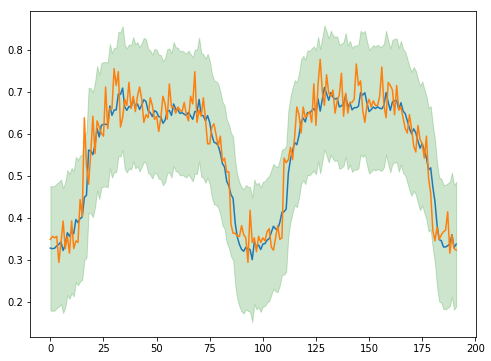

In [10]:
plt.figure(figsize=(8,6))
plt.plot(mu_pred)
plt.fill_between(range(192),upper,lower,color="green",alpha=0.2)
plt.plot(y_test[:192])

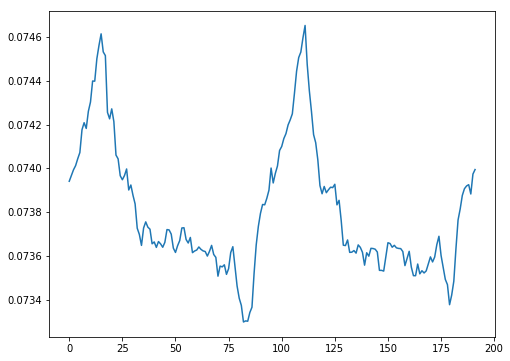

In [11]:
plt.figure(figsize=(8,6))
plt.plot(sigma_pred)

In [12]:
y_test.shape

(14007, 1)

In [13]:
y_test.reshape(-1)

array([0.34963788, 0.35691669, 0.35327729, ..., 0.22942825, 0.22214943,
       0.        ])

In [18]:
def show_interval(start,width=192):
    result=model.predict(X_test[start:start+width])
    mu_pred, sigma_pred=result[:,0],1/np.sqrt(result[:,1])
    upper = mu_pred+2*sigma_pred
    lower = mu_pred-2*sigma_pred
    plt.figure(figsize=(8,6))
    plt.plot(mu_pred,color='g',alpha=0.5)
    plt.fill_between(range(width),upper,lower,color="green",alpha=0.2)
    plt.plot(y_test[start:start+width])
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.plot(sigma_pred)
    plt.show()

0


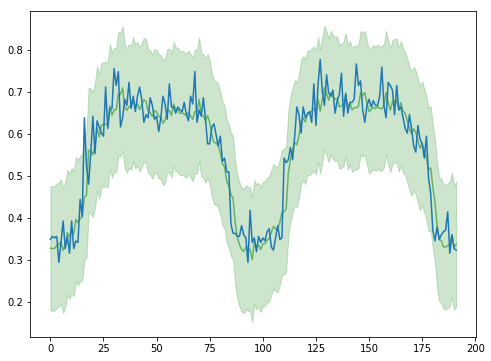

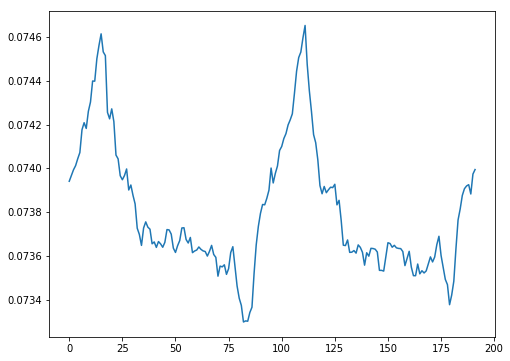

192


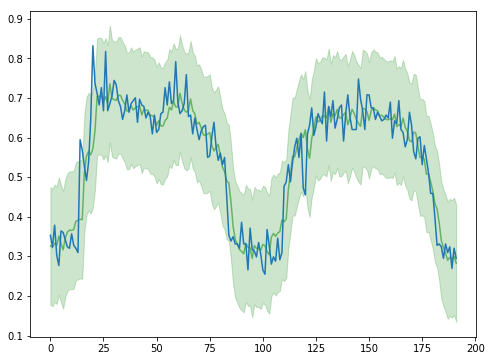

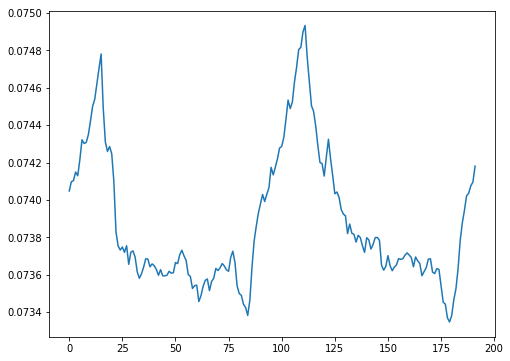

384


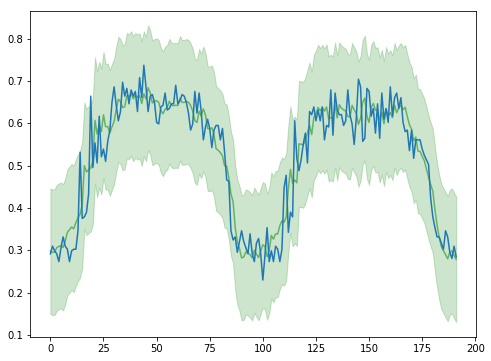

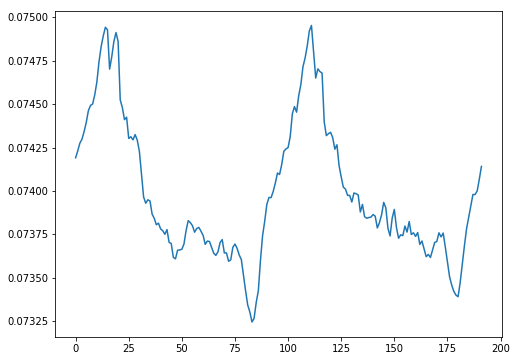

576


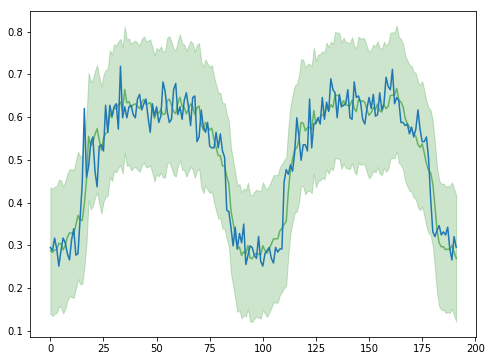

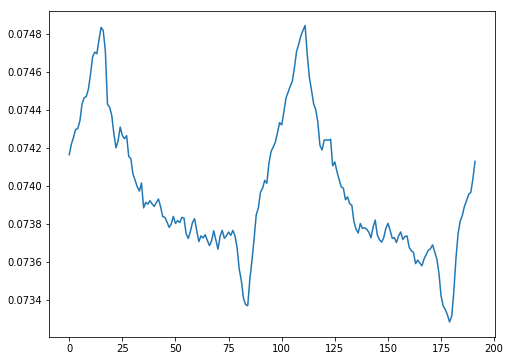

768


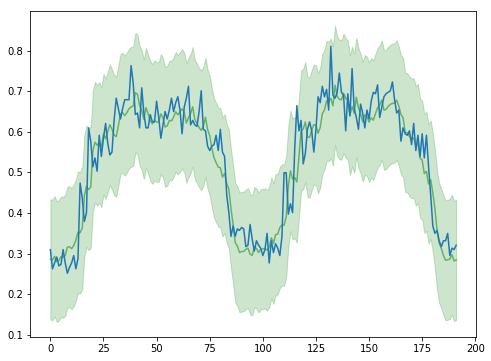

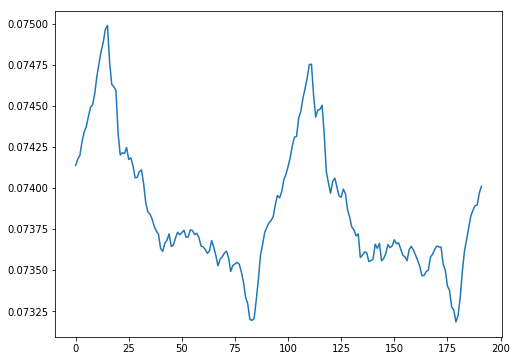

960


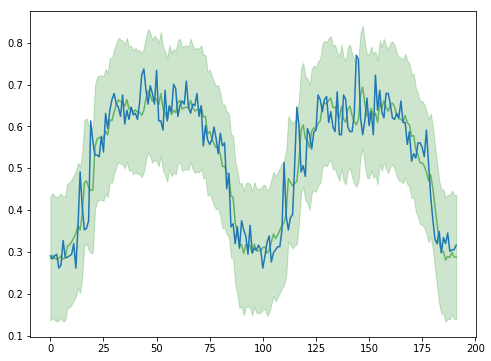

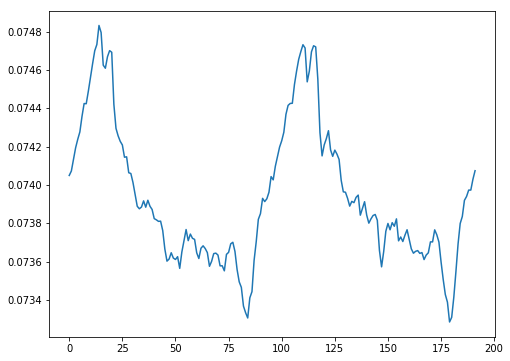

1152


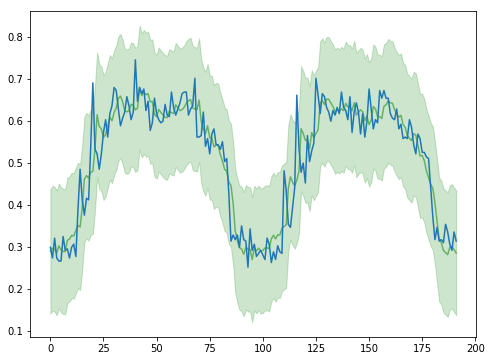

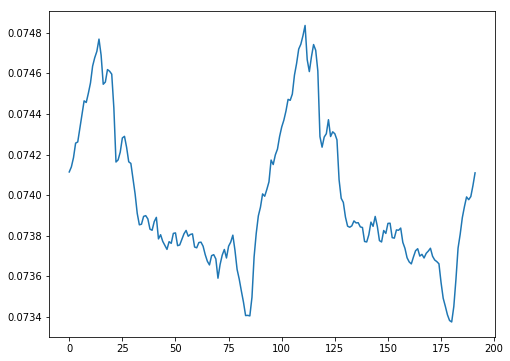

1344


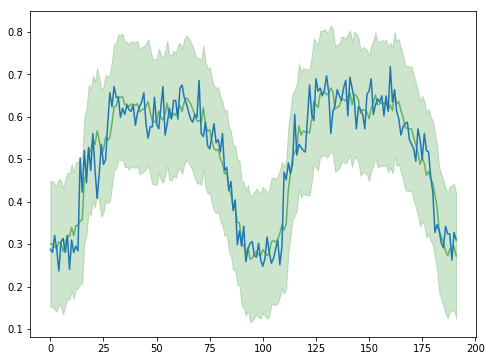

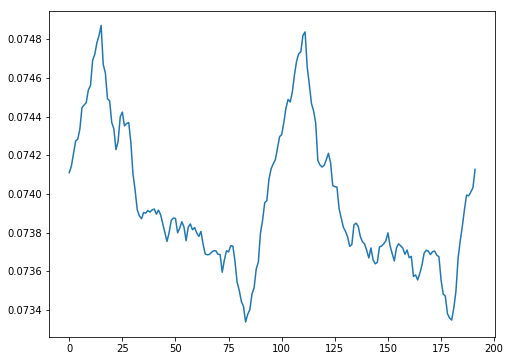

1536


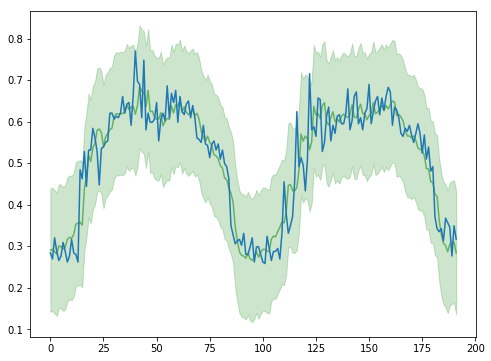

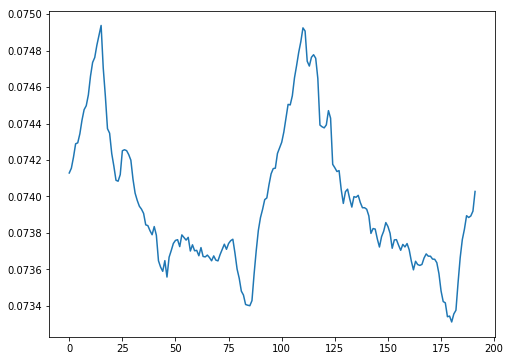

1728


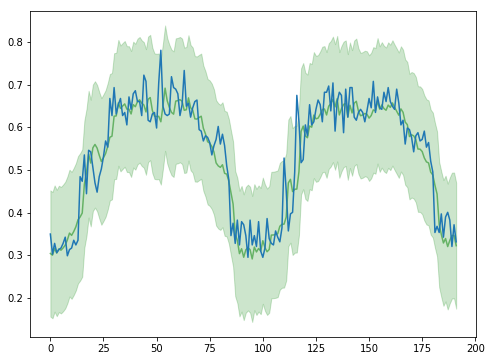

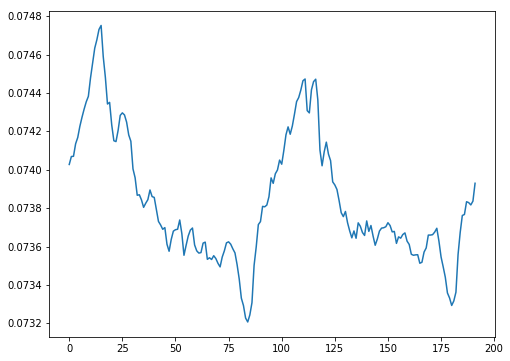

1920


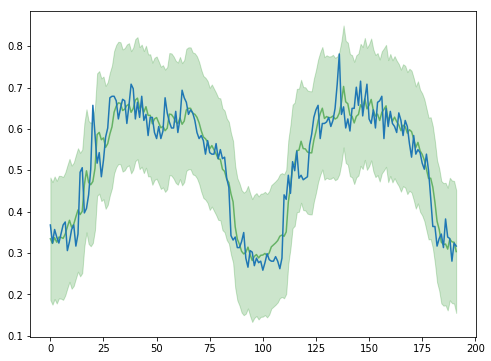

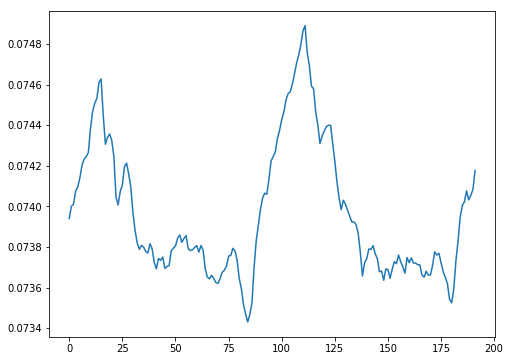

2112


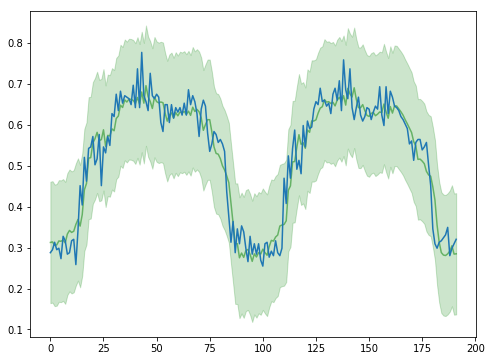

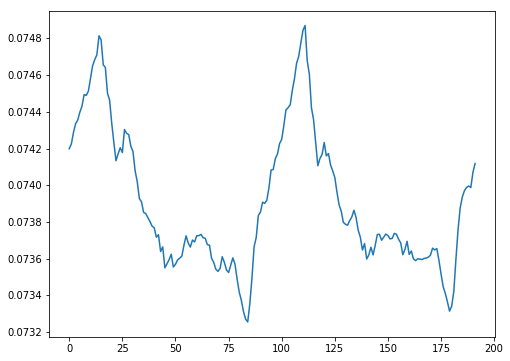

2304


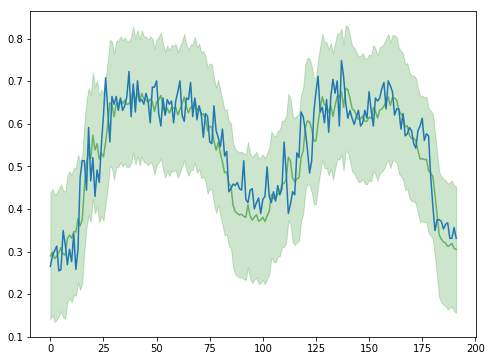

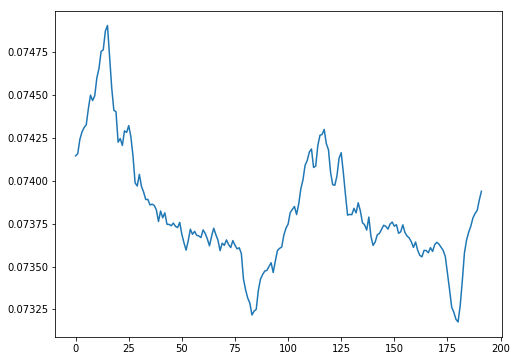

2496


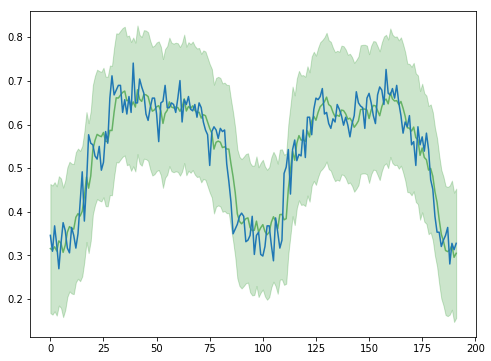

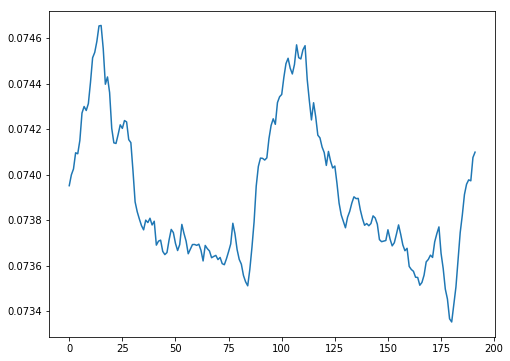

2688


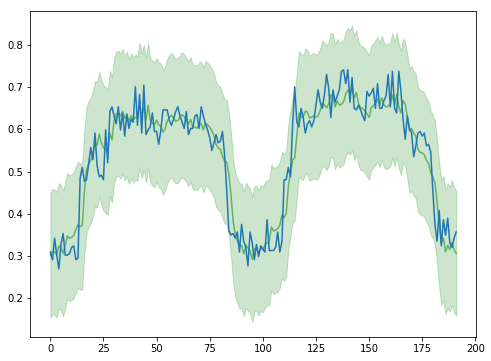

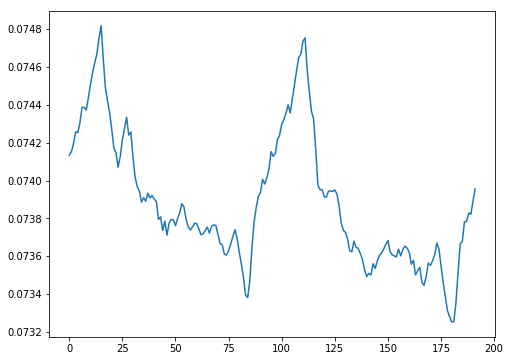

2880


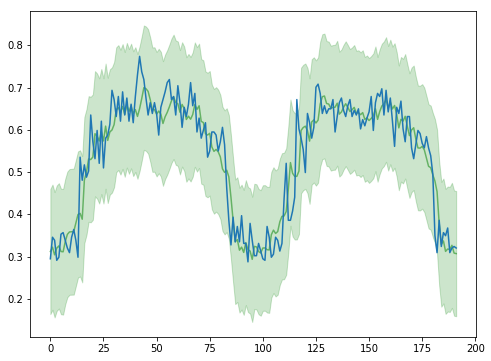

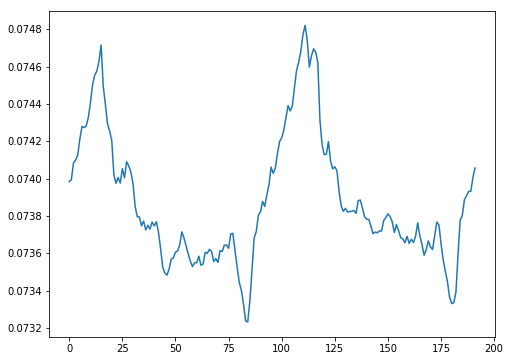

3072


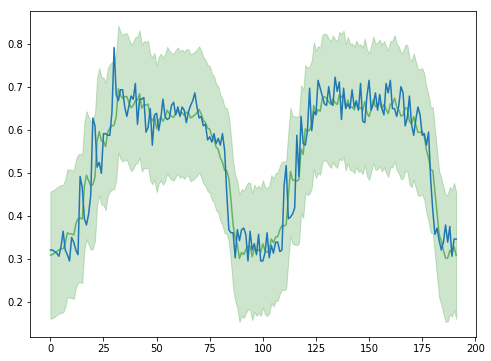

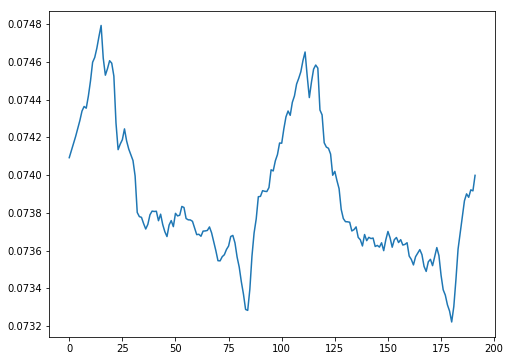

3264


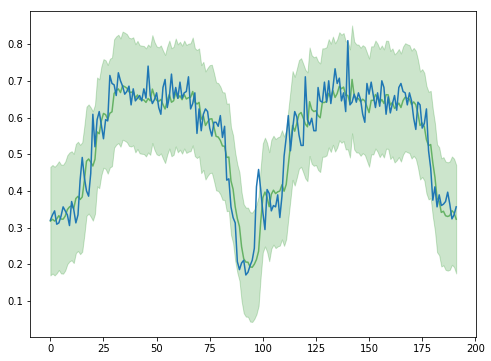

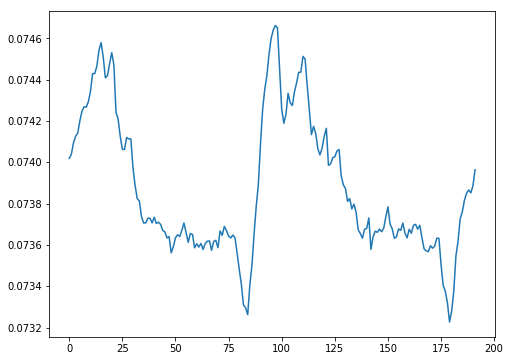

3456


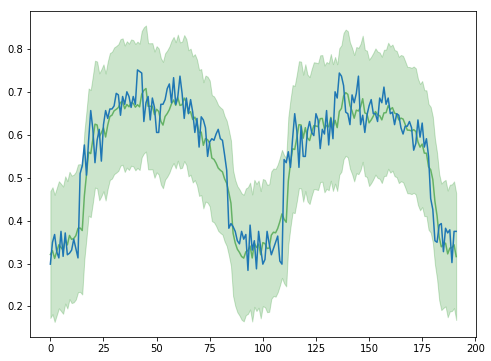

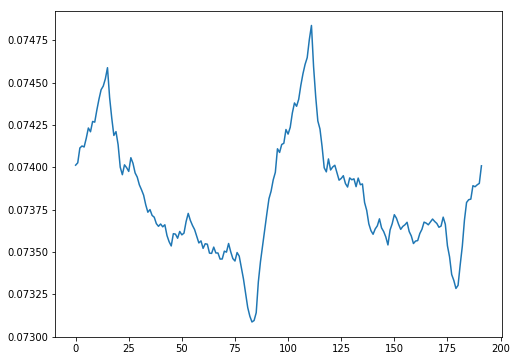

3648


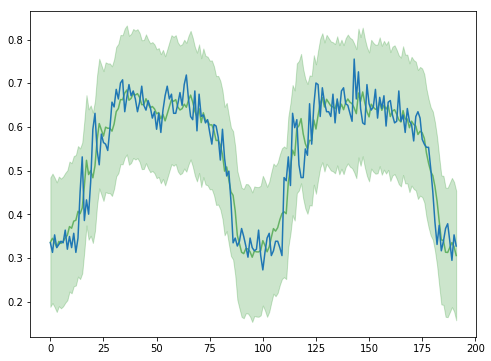

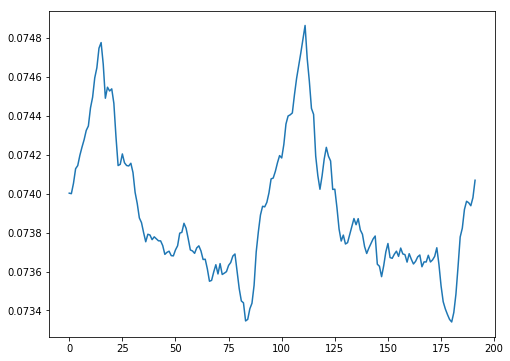

3840


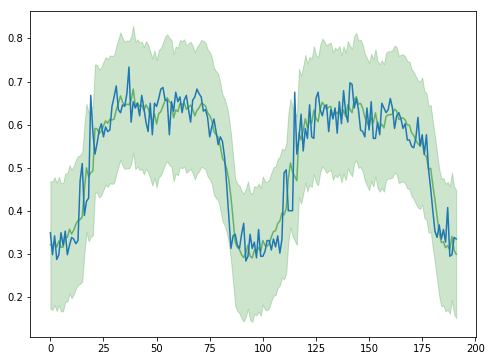

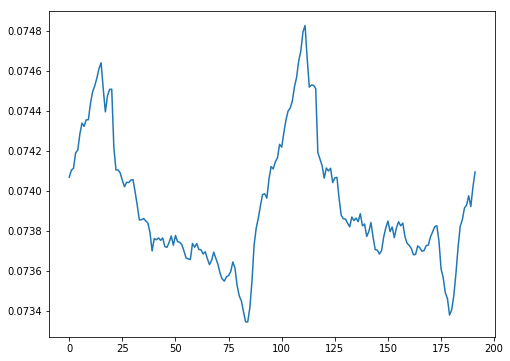

4032


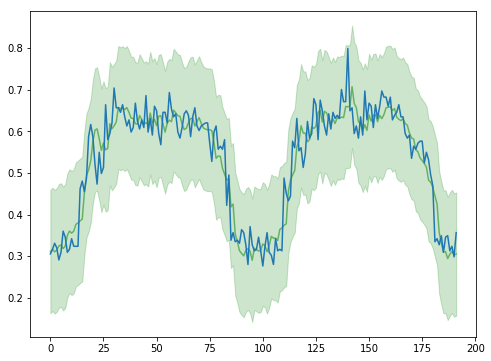

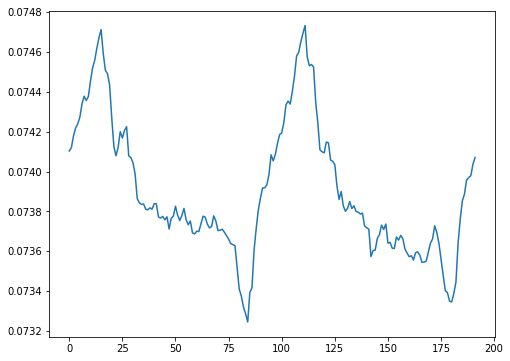

4224


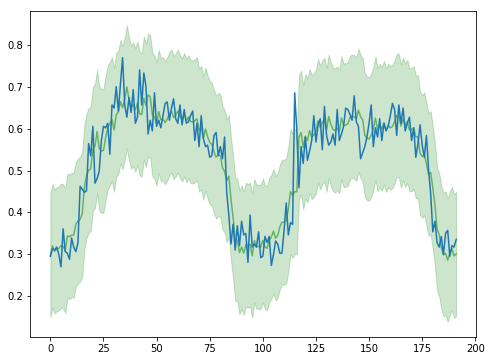

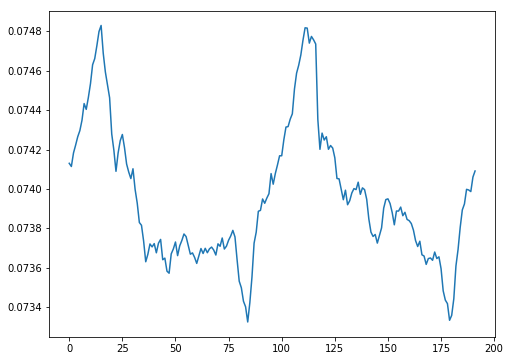

4416


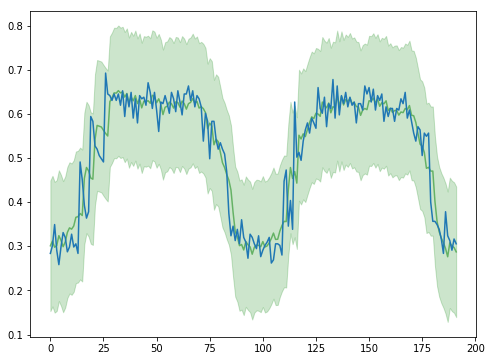

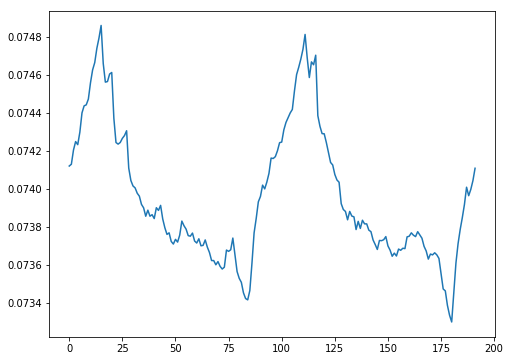

4608


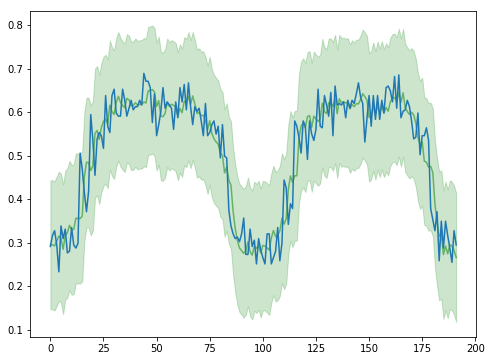

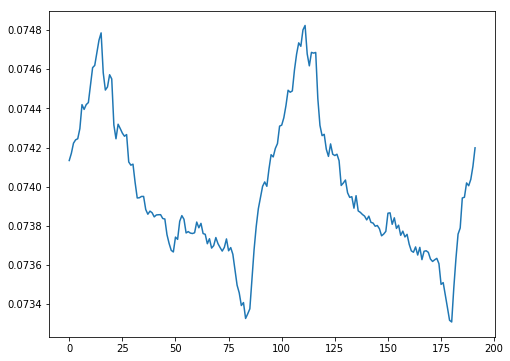

4800


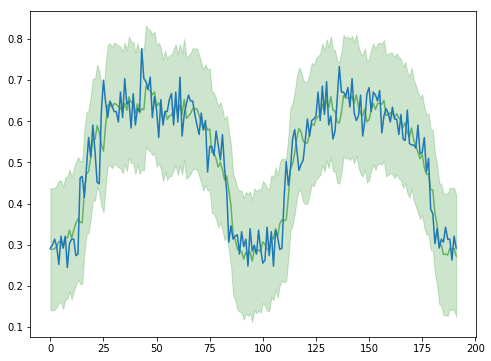

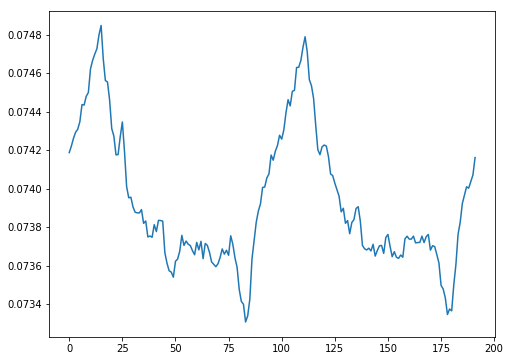

4992


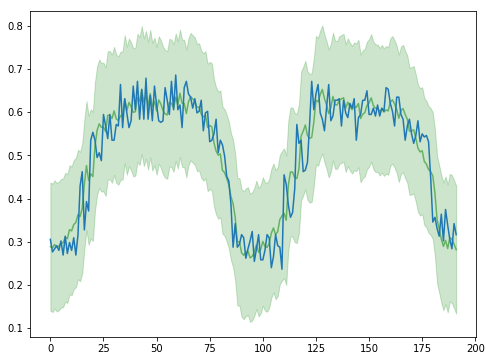

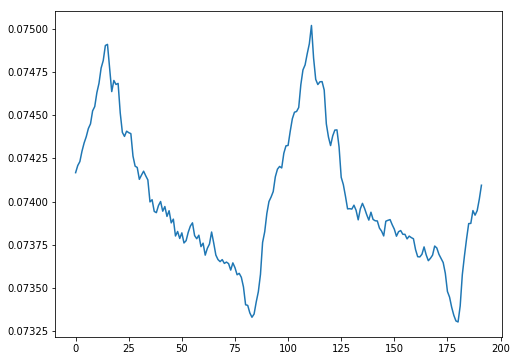

5184


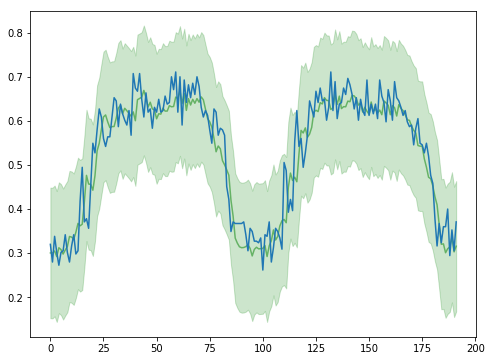

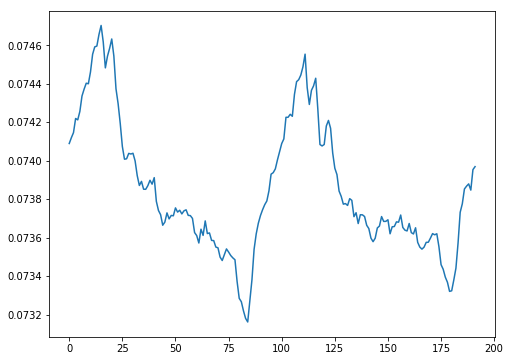

5376


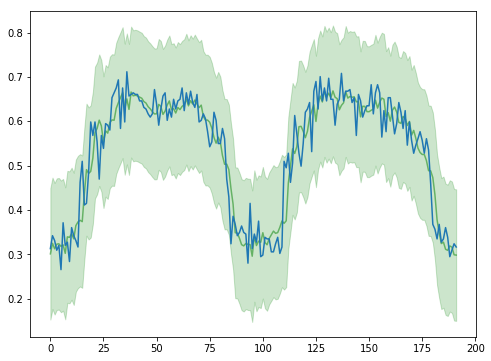

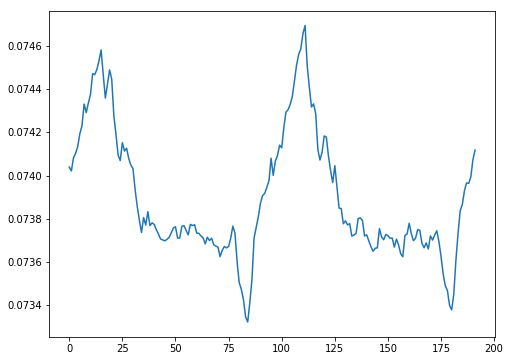

5568


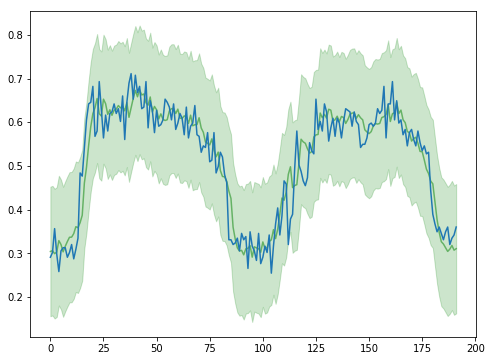

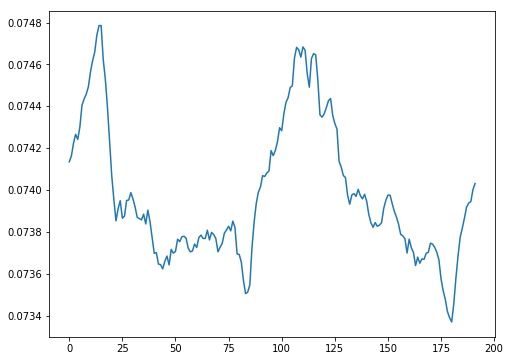

5760


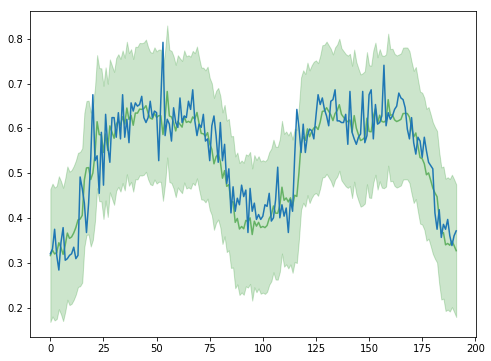

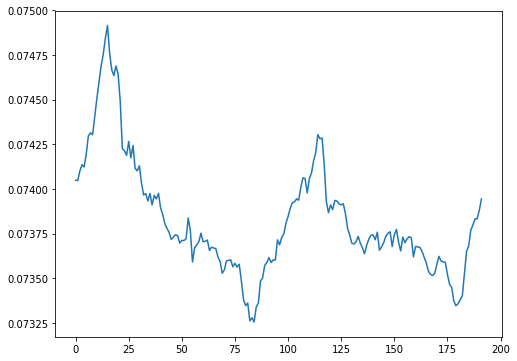

5952


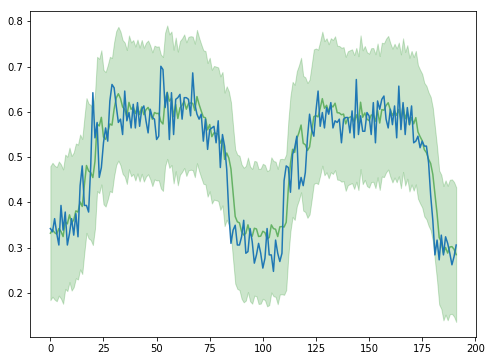

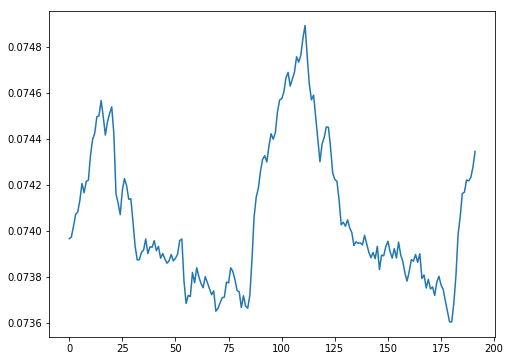

6144


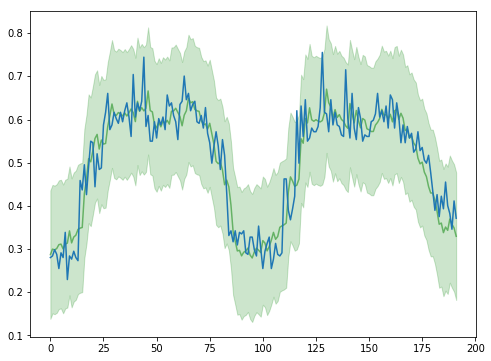

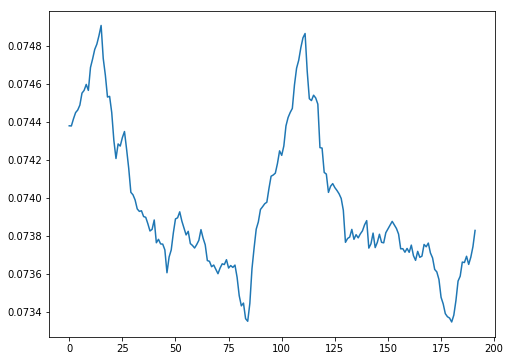

6336


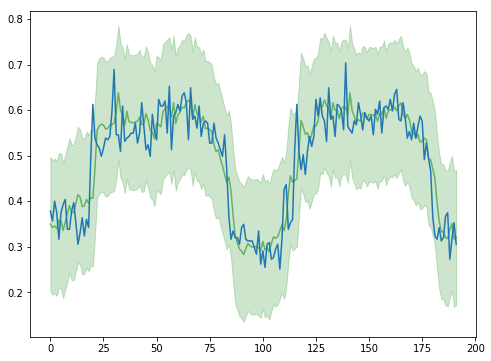

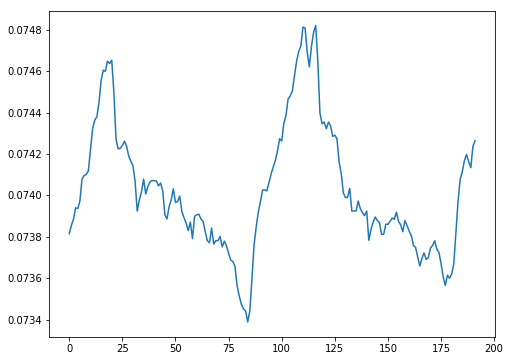

6528


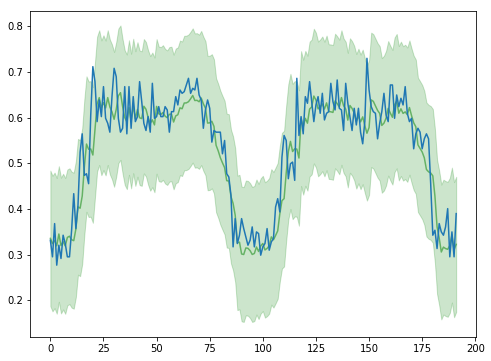

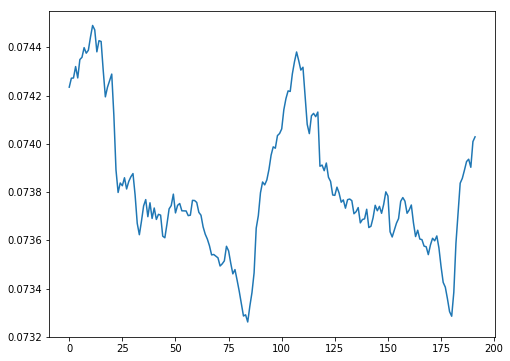

6720


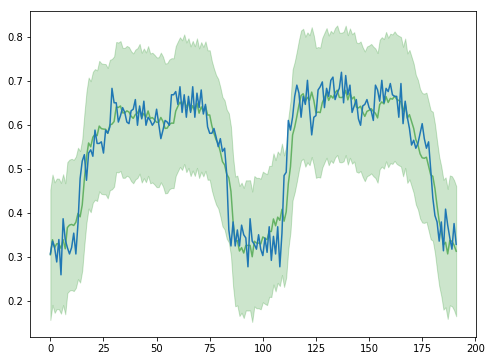

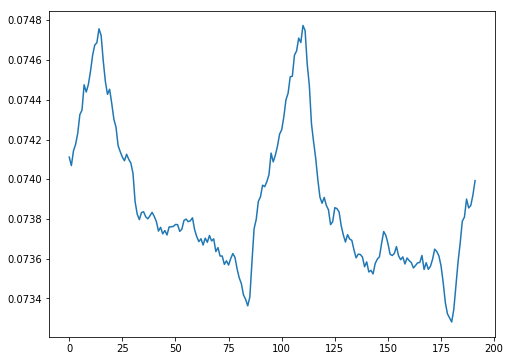

6912


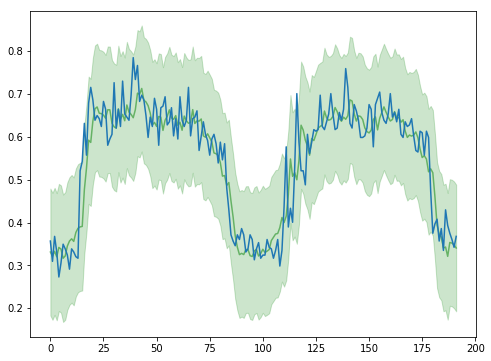

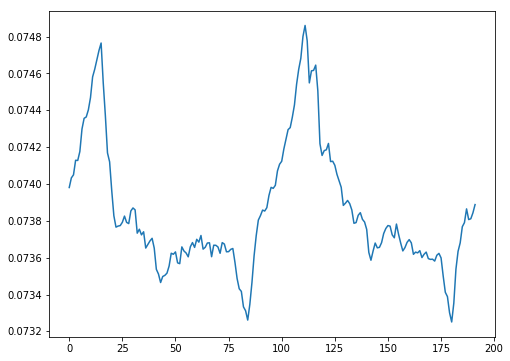

7104


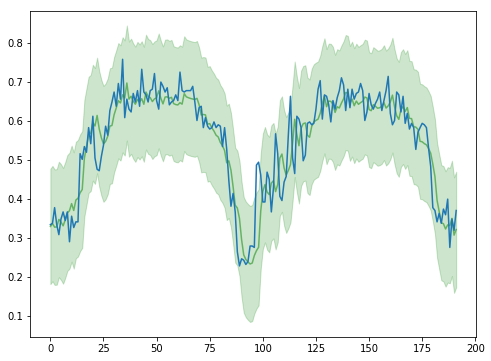

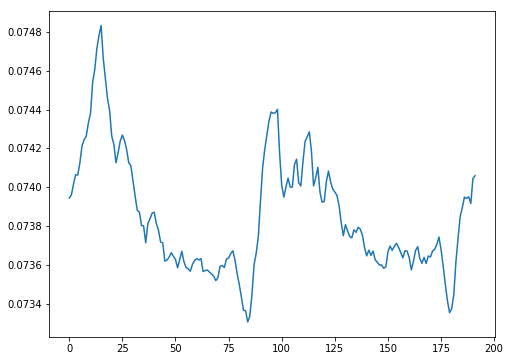

7296


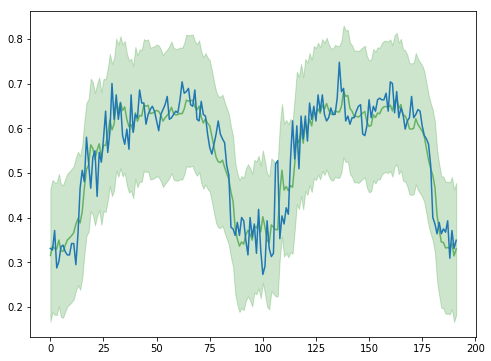

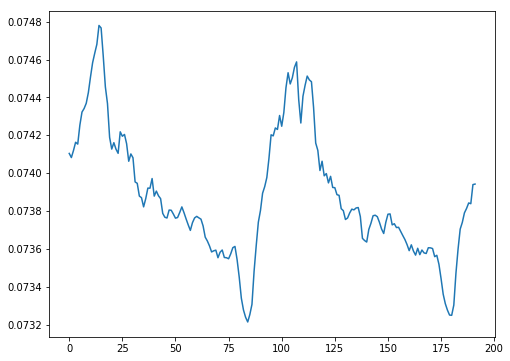

7488


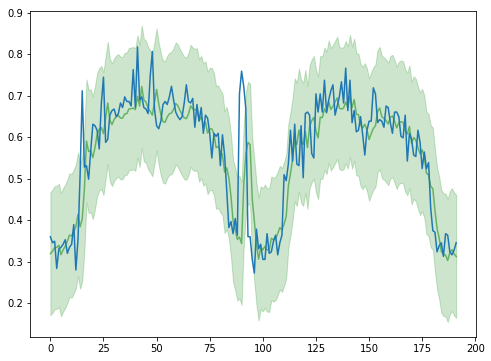

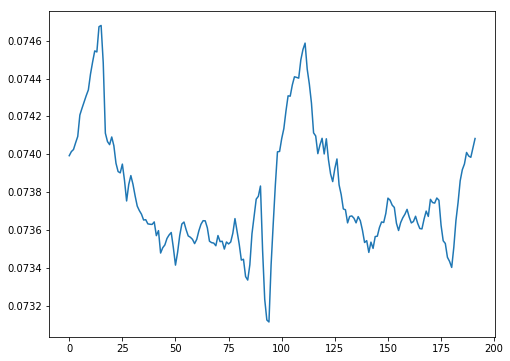

7680


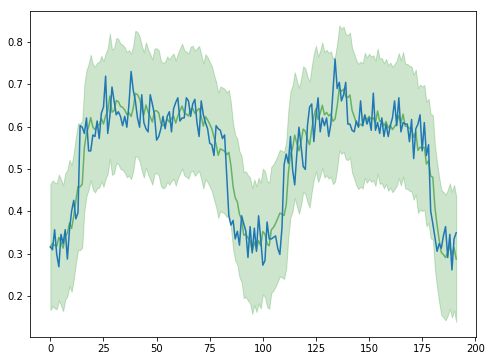

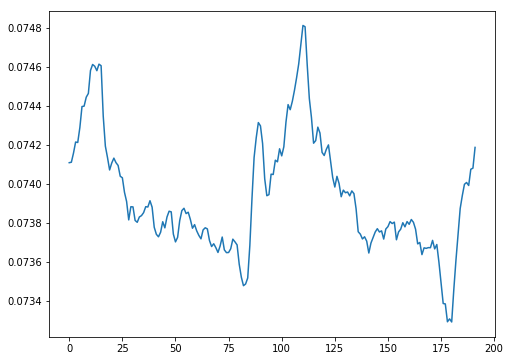

7872


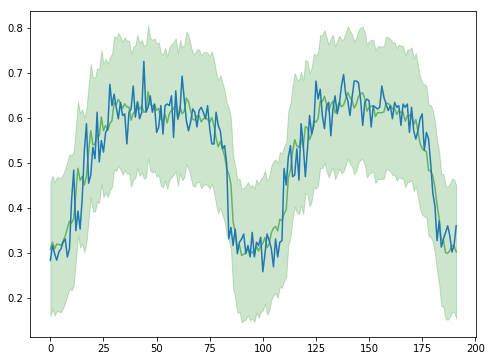

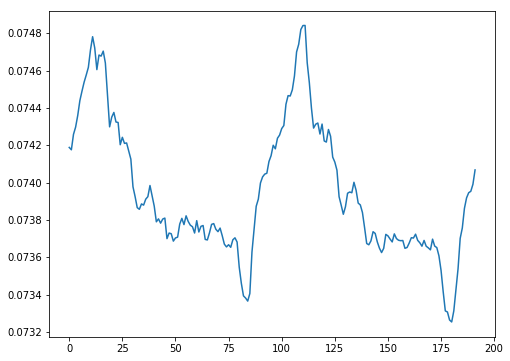

8064


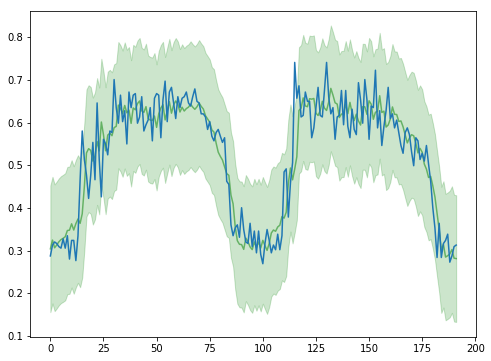

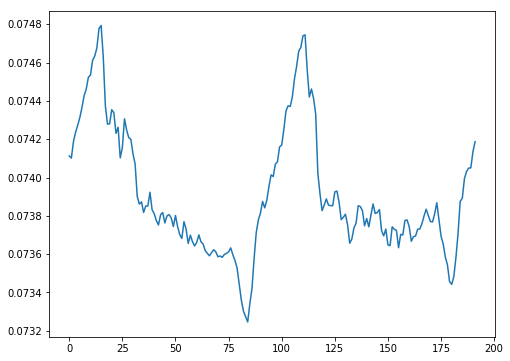

8256


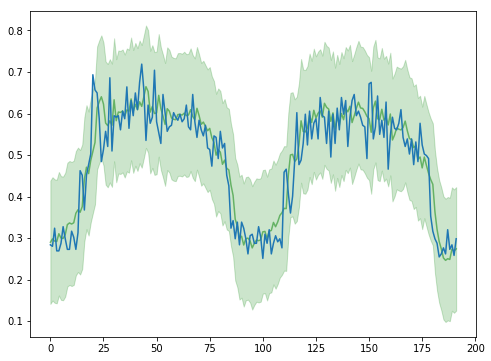

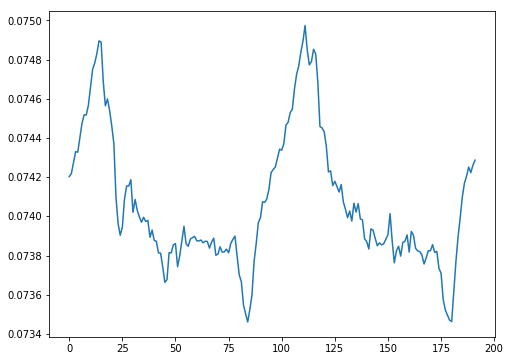

8448


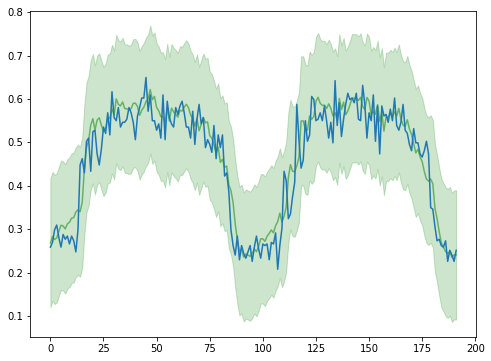

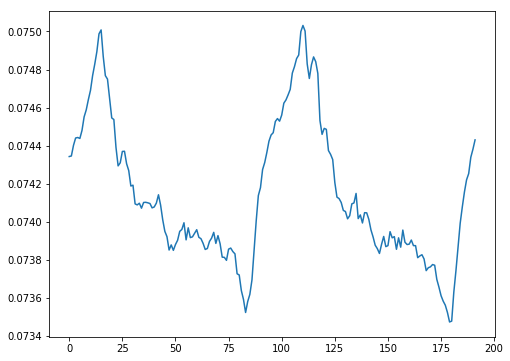

8640


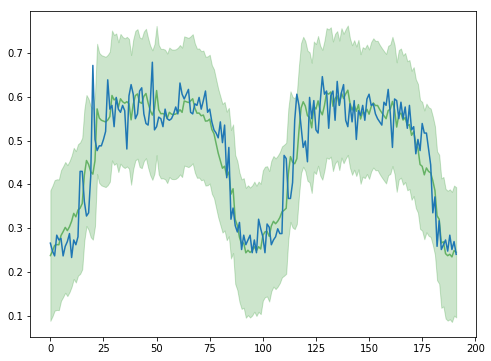

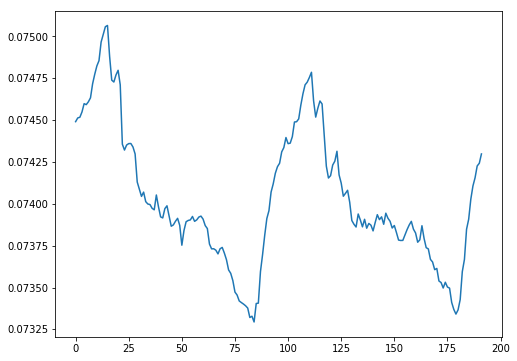

8832


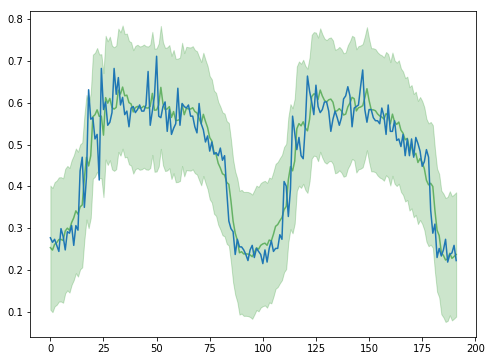

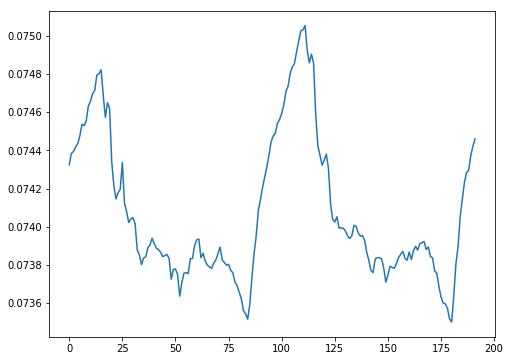

9024


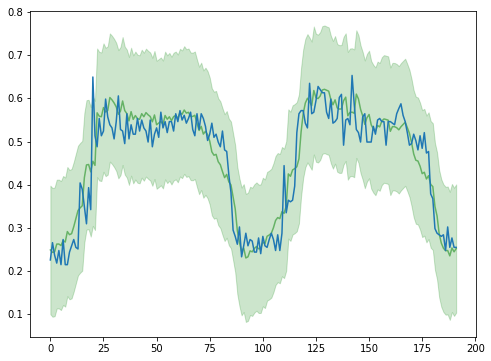

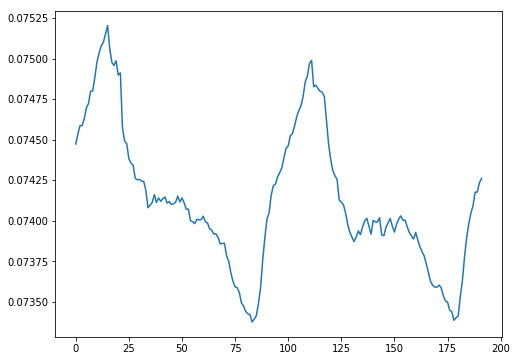

9216


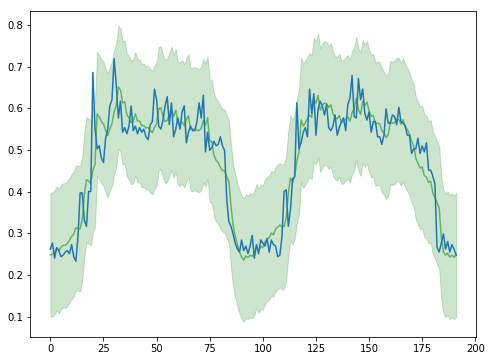

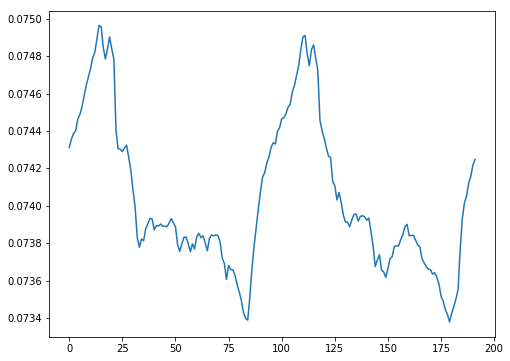

9408


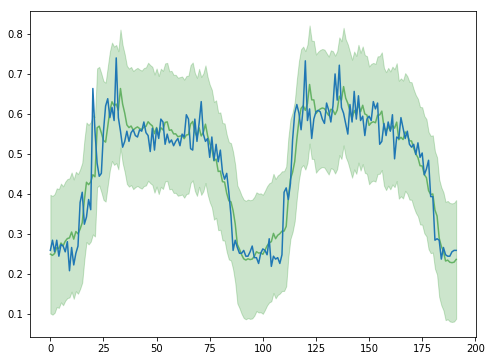

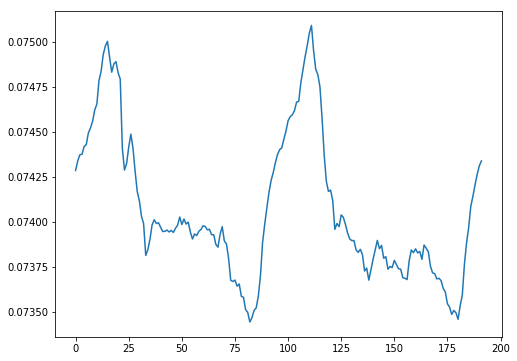

9600


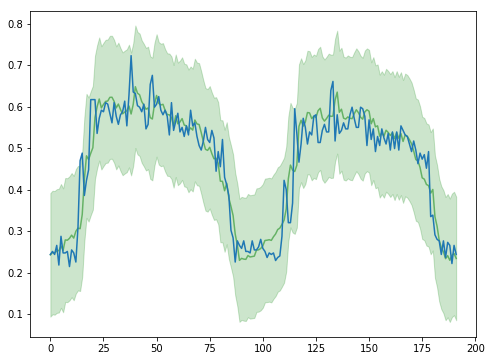

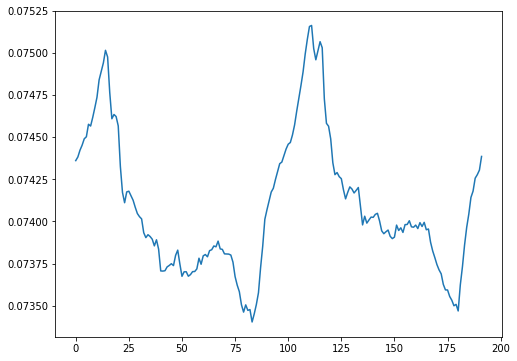

9792


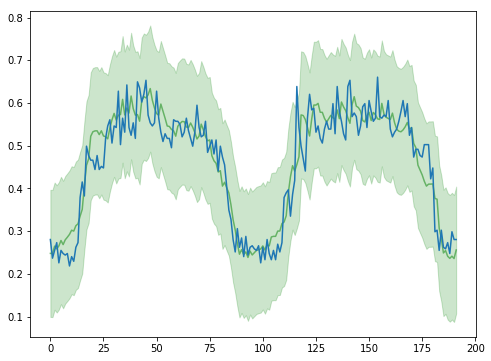

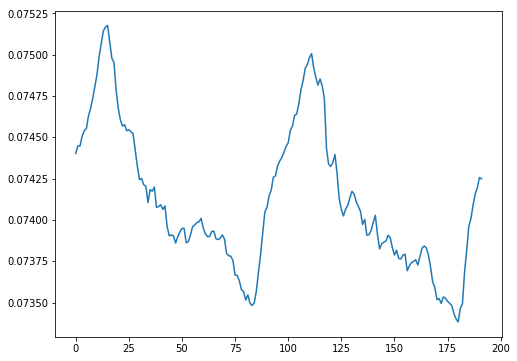

9984


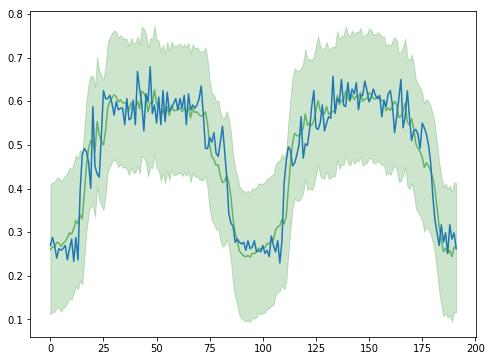

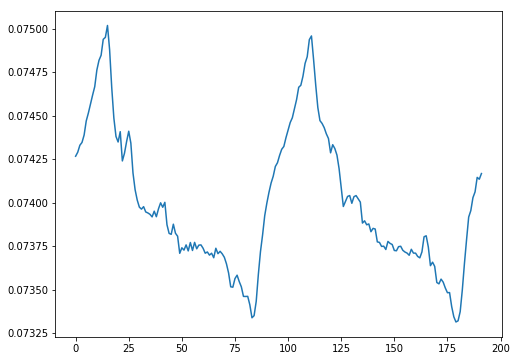

10176


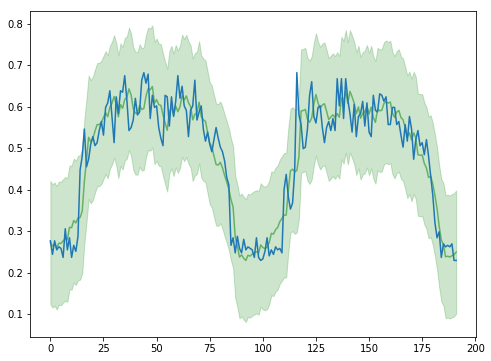

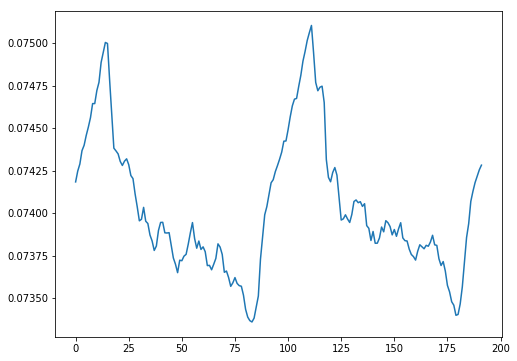

10368


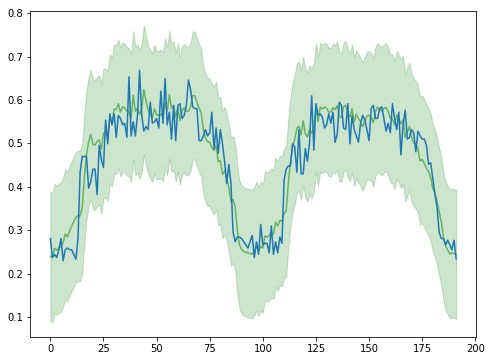

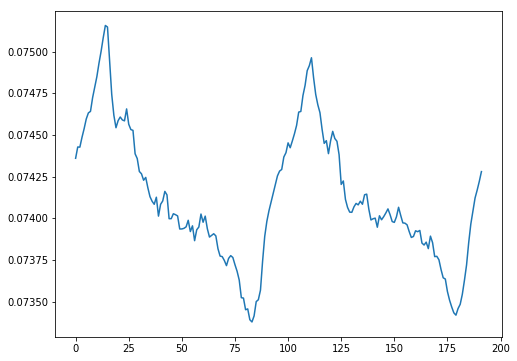

10560


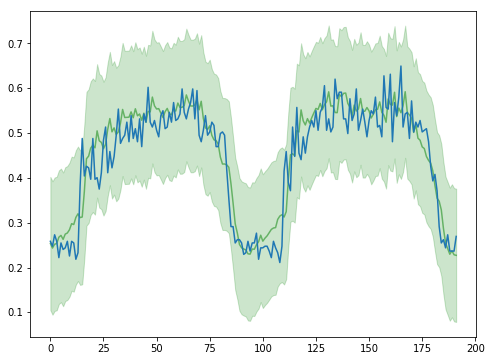

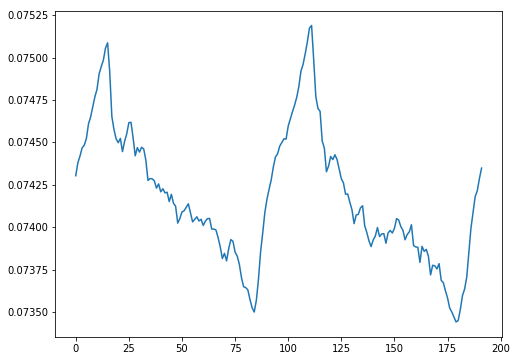

10752


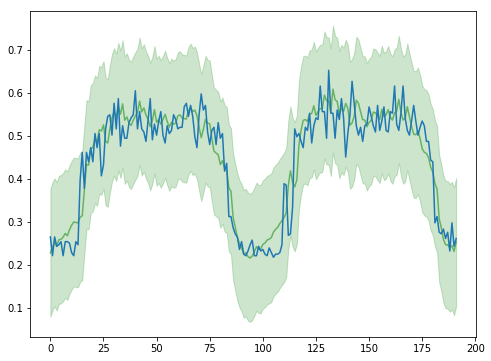

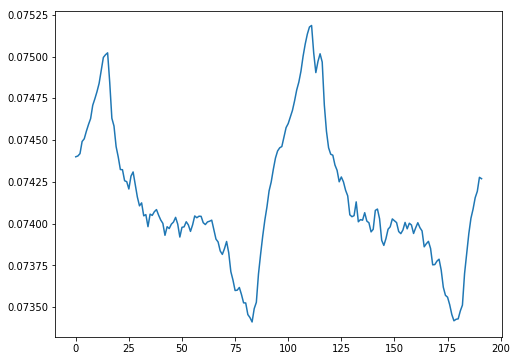

10944


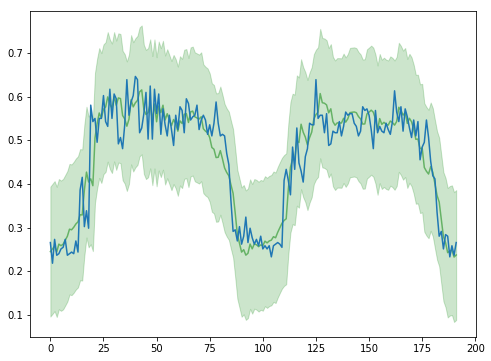

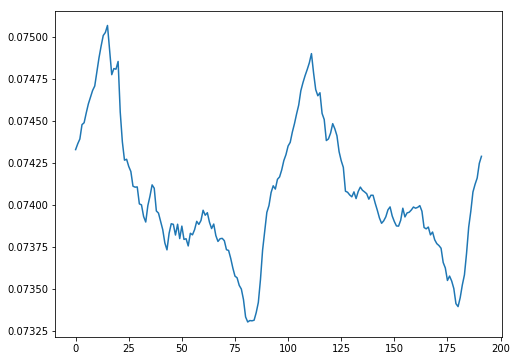

11136


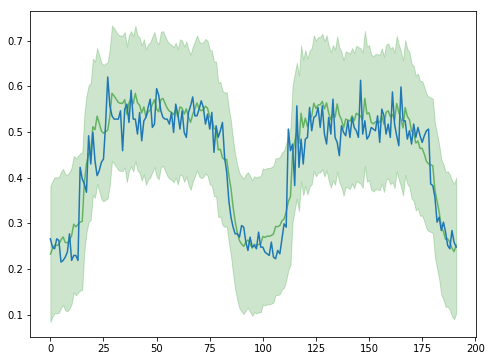

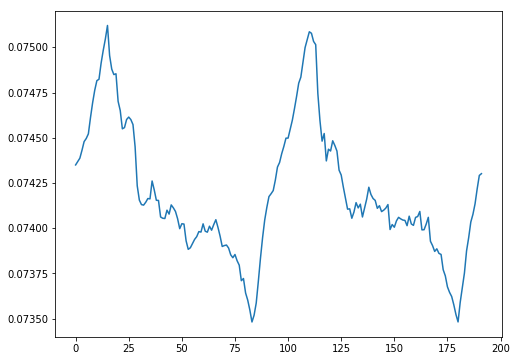

11328


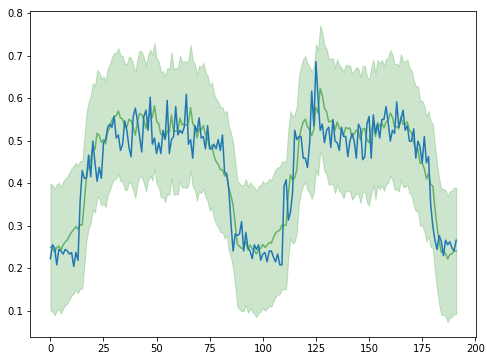

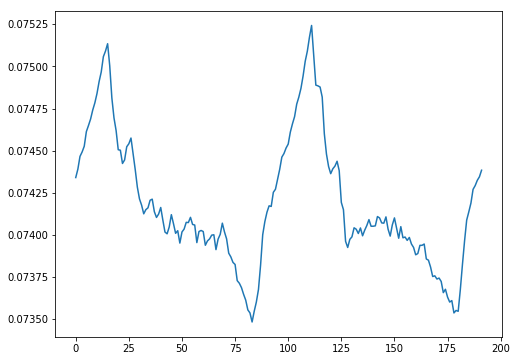

11520


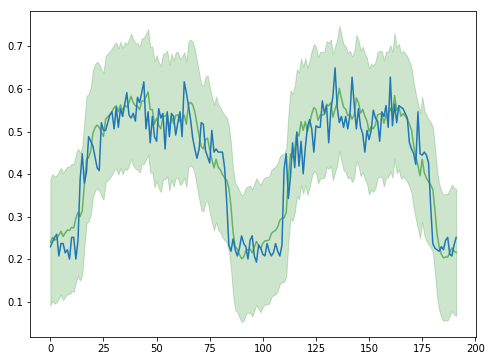

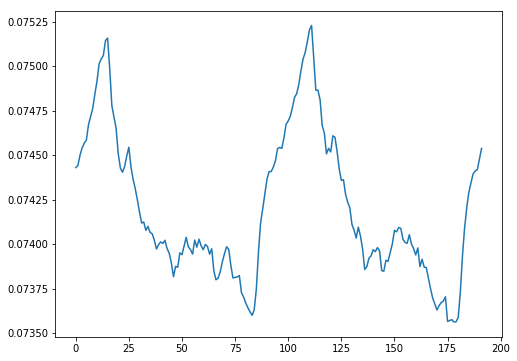

11712


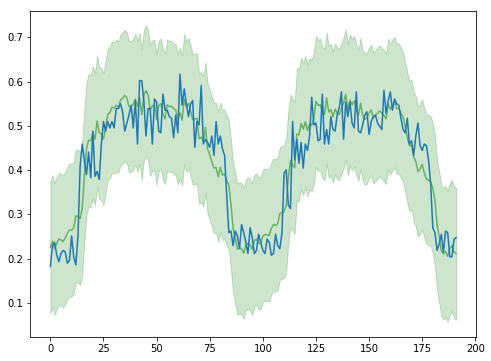

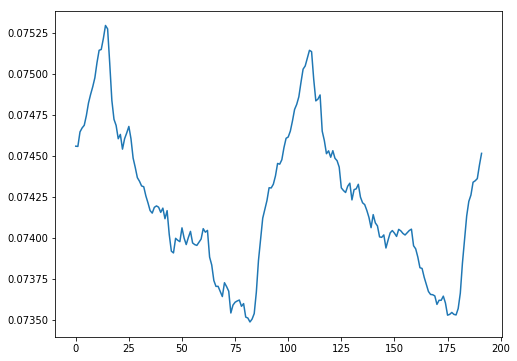

11904


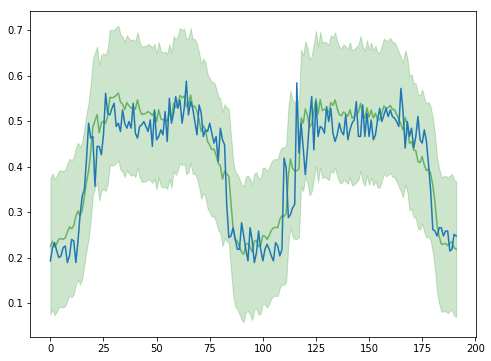

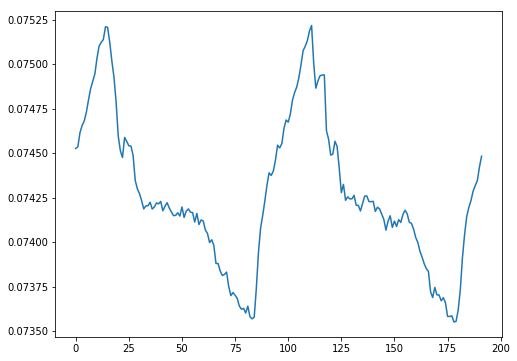

12096


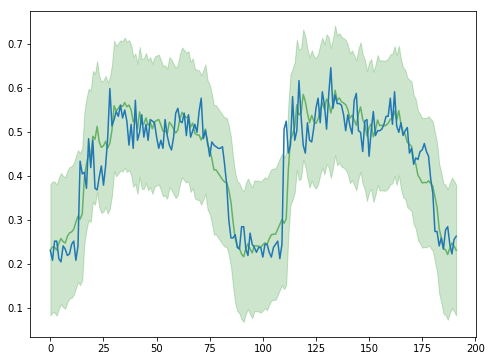

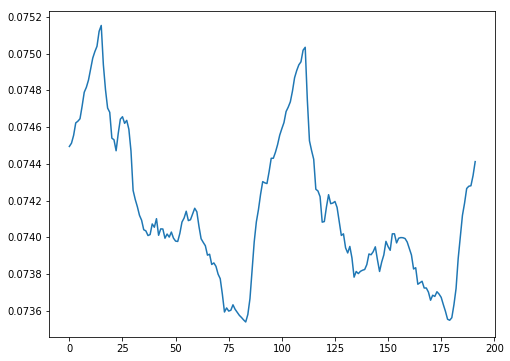

12288


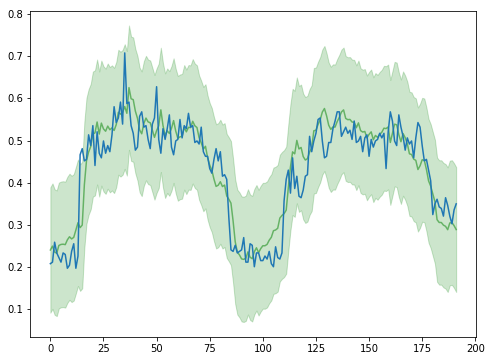

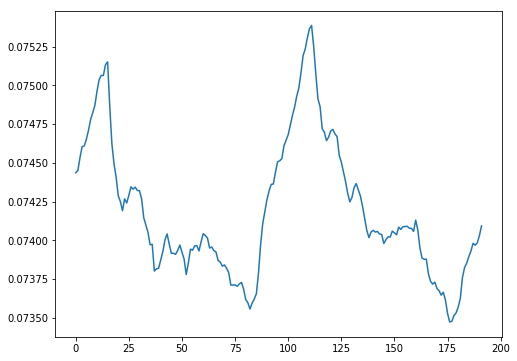

12480


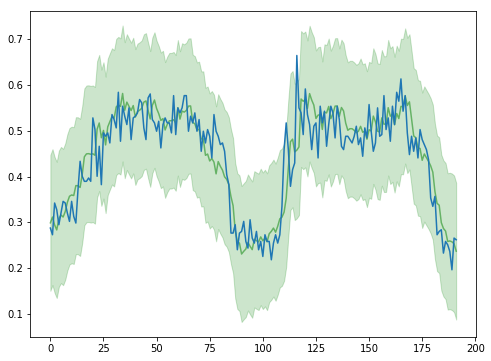

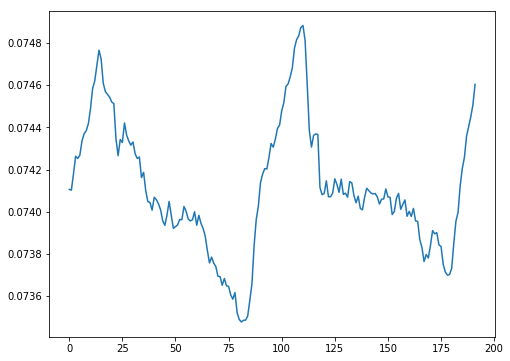

12672


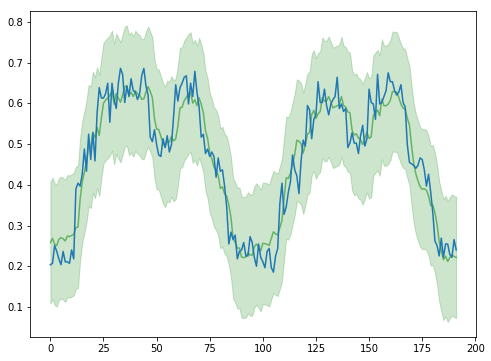

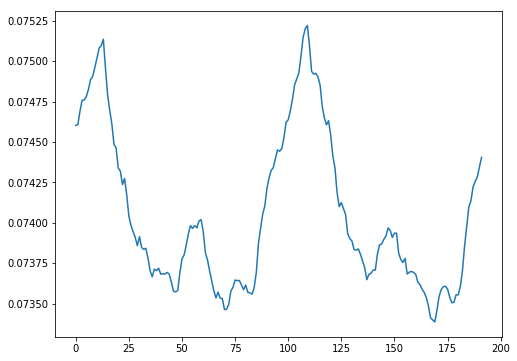

12864


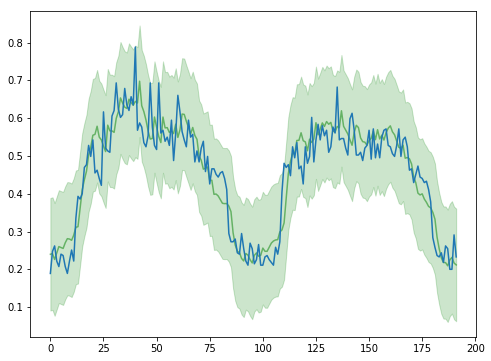

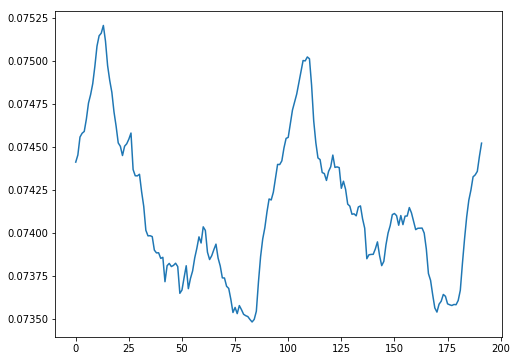

13056


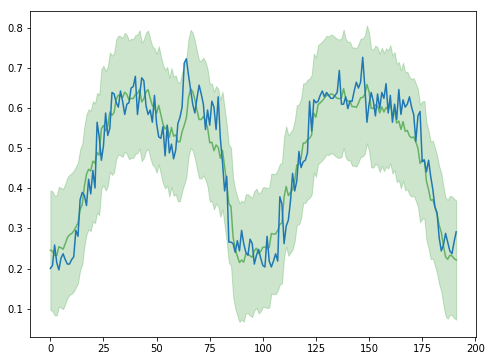

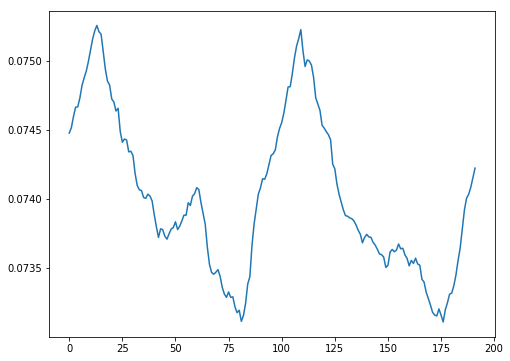

13248


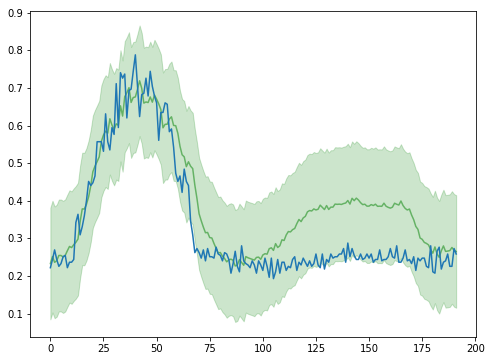

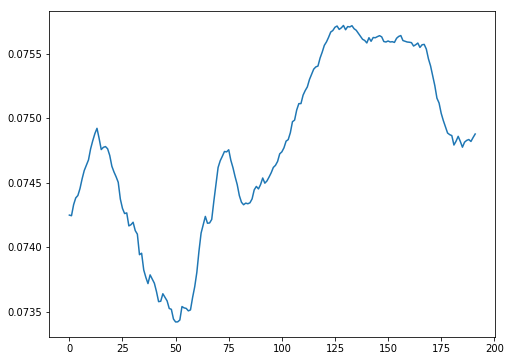

13440


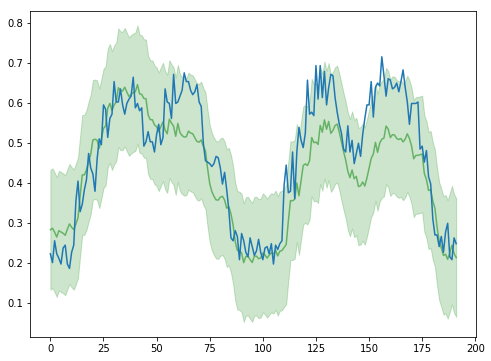

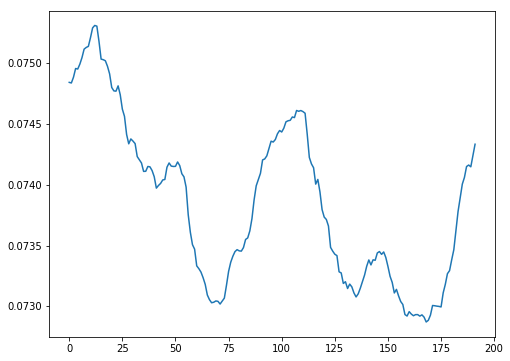

13632


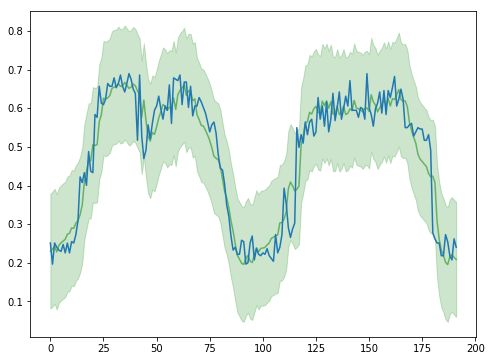

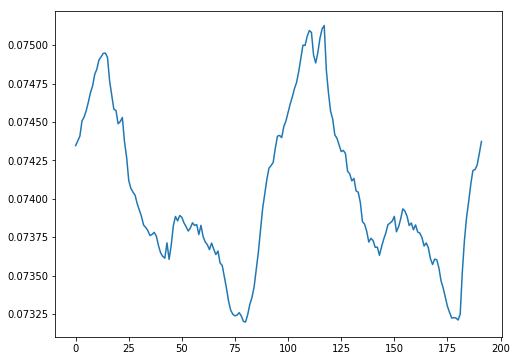

In [19]:
for i in range(0,len(y_test)-192,192):
    print(i)
    show_interval(i)